# SISPS-AST9AH-Analysis

Analysis for Asterion HR12-9 9AH batteries for SISPS project.

Lawrence Stanton  
**March 2024**

## Document Information

| **uYilo Order No** | UCT002 |


## Imports and Configuration


In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re


# Modify default plotting style
plt.style.use('dark_background')  # <--- comment toggle per visual preference
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (8, 5)
%config InlineBackend.figure_formats = ['svg']

nyquistRealAxisLabel = 'Real Impedance (mΩ)'
nyquistImagAxisLabel = 'Imaginary Impedance (mΩ)'

## Environmental Test Chamber (ETC) Data Import


<Axes: title={'center': 'ETC Temperature and Set Point History'}, xlabel='Date/Time'>

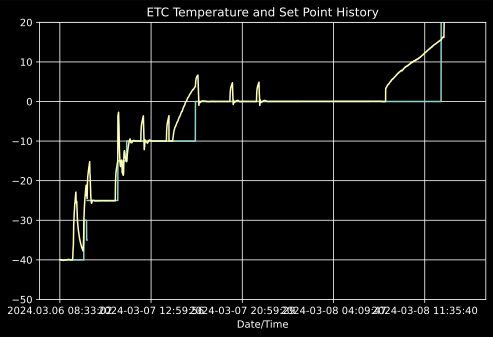

In [2]:
def readEtcFile(file):
	data = pd.read_csv(file,
					encoding='charmap',
					delimiter=';',
					usecols=['Date/Time', 'CV1_SP', 'CV1_AV'],
					parse_dates=['Date/Time'],
					date_format='%Y.%m.%d %H:%M:%S',
					)
	return data

def readAllEtcFiles(files):
	etc = None
	for file in files:
		data = readEtcFile(file)
		etc = pd.concat([etc, data])
	return etc

etcFiles = [
	"Data/ETC/Batch A/SERVICE-2024-03-06.csv",
	"Data/ETC/Batch A/SERVICE-2024-03-07.csv",
	"Data/ETC/Batch A/SERVICE-2024-03-08.csv",
]
etc = readAllEtcFiles(etcFiles)

# Dates might still need correction - settings change happened mid test
etc.plot(
	x='Date/Time',
	kind='line',
	ylim=(-50, 20),
	legend=False,
	title='ETC Temperature and Set Point History',
	grid=True,
	)


## Electrochemical Impedance Spectroscopy (EIS) Data Import


In [3]:
def readEisFile(file):
	headerRow = 30
	skipRow = lambda r: (r in range(0, headerRow-1)) or (r in range(headerRow, headerRow + 4)) # Constant offset for all EIS files.

	data = pd.read_csv(
		file,
		skiprows = skipRow,
		usecols = lambda col: col not in ["Voltage", "Current", "Cycle", "Cycle Level", "EisStart", "EisFinish", "AAcMax", "Unnamed: 42"],
	)

	metadata = pd.read_csv(
		file,
		nrows=23,
		skiprows=2,
		sep=',',
		names=['key', 'value'],
		)
	metadata = metadata.set_index('key').to_dict()['value']

	return (data, metadata)

def readAllEisFiles(files):
	eis = {}
	for file in files:
		data, metadata = readEisFile(file)
		eis[metadata['Comment']] = (data, metadata)
	return eis


def findAllEisFiles():
	files = []
	for root, dirs, file in os.walk('Data/EIS'):
		for f in file:
			if f.endswith('_EIS00001.csv'):
				files.append(os.path.join(root, f))
	return files

eis = readAllEisFiles(findAllEisFiles())


### EIS Data Preprocessing

- Sorting eis elements by test name.
- Known bad tests are removed from the main eis batch but saved separately for later reference if necessary.
- Special processing of A10 -20°C EIS data.

  > The measurement appeared corrupted in some data points due to the battery suspected of being frozen. When negative real values are removed however, the remaining pattern appears useful.

- Rename RT to RT1 for clarity.
- Add the Temperature and SoC as EIS metadata.
- Add the mean DC Voltage as EIS metadata.


In [4]:
# This cell can only run once, as it modifies the eis dictionary.

eis = dict(sorted(eis.items()))	# Helps some legends by plotting in alphabetical order

knownBadTests = [
	"UCT_AST_A01_-20 FAIL",
	"UCT_AST_A10_-20 FAIL",
	"UCT_AST_A03_-30 FAIL",
	"UCT_AST_A09_-30 FAIL",
	"UCT_AST_9AH_A01_-20_POC",
	"UCT_AST_9AH_A02_-20_POC",
	"UCT_AST_9AH_A03_-20_POC",
	"UCT_AST_9AH_A04_-20_POC",
	"UCT_AST_9AH_A05_-20_POC",
	"UCT_AST_9AH_A06_-20_POC",
]

def filterBadTests(eis, knownBadTests):
	eisBadTests = {}
	for badTest in knownBadTests:
		eisBadTests[badTest] = eis[badTest]
		del eis[badTest]
	return eisBadTests

eisBadTests = filterBadTests(eis, knownBadTests)

# Special case filtering for obviously invalid rows of A10 -20°C tests
def a10badDataRowFilter(eis):
	for a10spectra in eis:
		if 'UCT_AST_A10_-20' in a10spectra:
			spectra = eis[a10spectra]
			# filter all rows where Zreal1 < 0
			filteredSpectra = (spectra[0][spectra[0]['Zreal1'] > 0], spectra[1])
			eis[a10spectra] = filteredSpectra
	return eis

eis = a10badDataRowFilter(eis)

def renameToRT1(eis):
	renamedEis = {}
	for spectra in eis:
		if spectra.endswith('RT'):
			renamedEis[spectra.replace('RT', 'RT1')] = eis[spectra]
		else:
			renamedEis[spectra] = eis[spectra]

	return renamedEis

eis = renameToRT1(eis)


In [5]:
socMap = {
	"A01": "100%",
	"A02": "93%",
	"A03": "87%",
	"A04": "80%",
	"A05": "73%",
	"A06": "67%",
	"A07": "60%",
	"A08": "53%",
	"A09": "47%",
	"A10": "40%",
}

def addSocMetadata(eis, socMap):
	for spectra in eis:
		socText = re.search(r'A\d{2}', spectra).group(0)
		eis[spectra][1]['SoC'] = socMap[socText]
	return eis

eis = addSocMetadata(eis, socMap)

temperatureMap = {
	"RT1": 25,
	"-40": -40,
	"-30": -30,
	"-20": -20,
	"-10": -10,
	"_0": 0,
	"RT2": 25,
}

def addTemperatureMetadata(eis, temperatureMap):
	for spectra in eis:
		temperatureText = re.search(r'RT1|-40|-30|-20|-10|_0|RT2', spectra).group(0)
		eis[spectra][1]['Temperature'] = temperatureMap[temperatureText]
	return eis

eis = addTemperatureMetadata(eis, temperatureMap)

def addDcVoltageMetadata(eis):
	for spectra in eis:
		eis[spectra][1]['DcVoltage'] = eis[spectra][0]['U1'].mean()
	return eis

eis = addDcVoltageMetadata(eis)


## Plot Individual EIS Spectra


In [6]:
def plotEisIndividual(eis):
	for spectra in eis:
		plot = eis[spectra][0].plot(
			x = 'Zreal1',
			y = 'Zimg1',
			grid = True,
			title = spectra,
			legend = False,
			figsize = (4, 3),
			marker = '.',
		)
		plot.invert_yaxis()
		plot.set_aspect('equal', adjustable='box')  # Fix: Replace plot.gca().set_aspect('equal', adjustable='box') with plot.set_aspect('equal', adjustable='box')
		plot.set_xlabel(nyquistRealAxisLabel)
		plot.set_ylabel(nyquistImagAxisLabel)
		plot.set_xlim(left = 0)

# plotEisIndividual(eis)
	

## Sort EIS Data into SoC and Temperature Groupings


In [7]:
def filterEisByTemperature(eis, temperatureCategories):
	eisTemperature = {}
	for category in temperatureCategories:
		eisTemperature[category] = {}
		for spectra in eis:
			if category in spectra:
				eisTemperature[category][spectra] = eis[spectra]
	return eisTemperature

eisTemperature = filterEisByTemperature(eis, temperatureMap.keys())

def filterEisBySoc(eis, socCategories):
	eisSoc = {}
	for category in socCategories:
		eisSoc[category] = {}
		for spectra in eis:
			if category in spectra:
				eisSoc[category][spectra] = eis[spectra]
	return eisSoc
	

eisSoc = filterEisBySoc(eis, socMap.keys())

## Fixed Temperature Varied SoC EIS Spectra


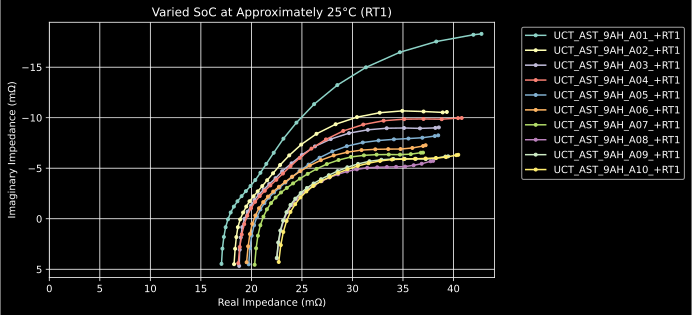

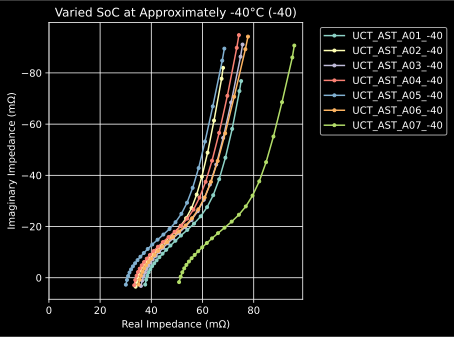

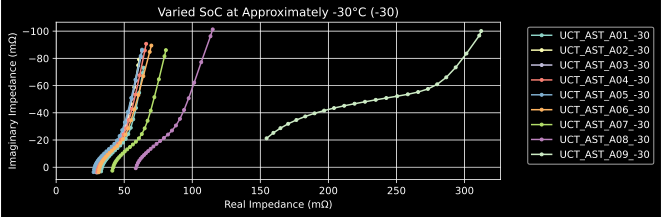

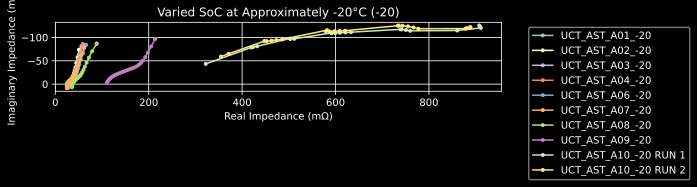

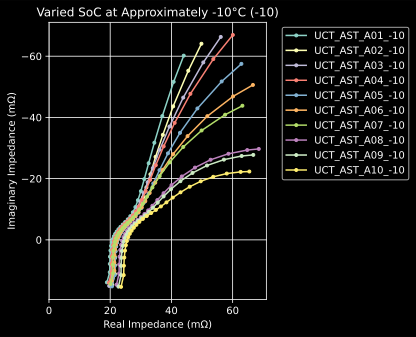

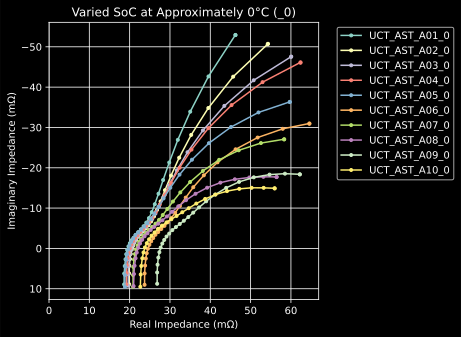

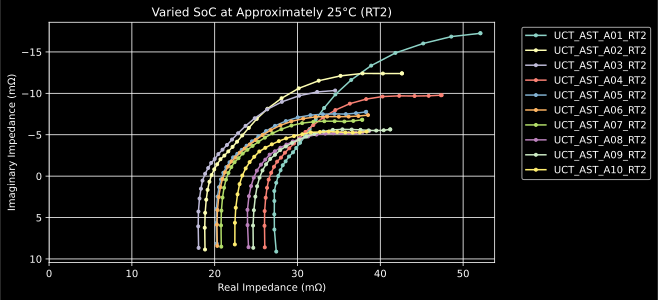

In [8]:
def plotAllTemperatureSpectra(eisTemperature):
	for category in eisTemperature:
		plot = None
		for spectra in eisTemperature[category]:
			plot = eisTemperature[category][spectra][0].plot(
				x = 'Zreal1',
				y = 'Zimg1',
				grid = True,
				title = f"Varied SoC at Approximately {temperatureMap[category]}°C ({category})",
				legend = True,
				label = f"{spectra}",
				figsize = (8, 5),
				marker = '.',
				ax = plot,
			)
		plot.invert_yaxis()
		plot.set_aspect('equal', adjustable='box')  # Fix: Replace plot.gca().set_aspect('equal', adjustable='box') with plot.set_aspect('equal', adjustable='box')
		plot.set_xlabel(nyquistRealAxisLabel)
		plot.set_ylabel(nyquistImagAxisLabel)
		plot.set_xlim(left = 0)
		plot.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0), ncol=1)

plotAllTemperatureSpectra(eisTemperature)

## Fixed SoC Varied Temperature EIS Spectra


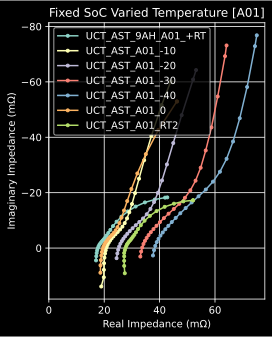

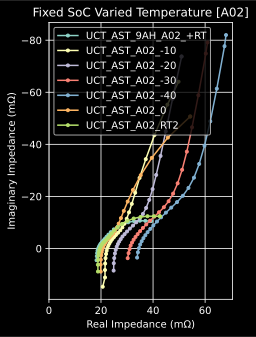

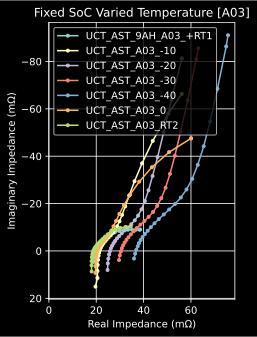

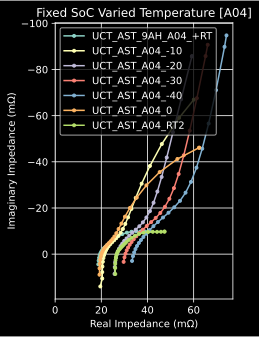

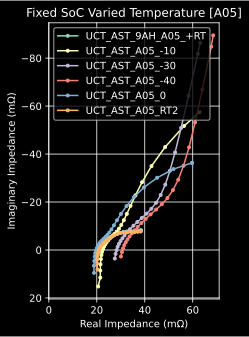

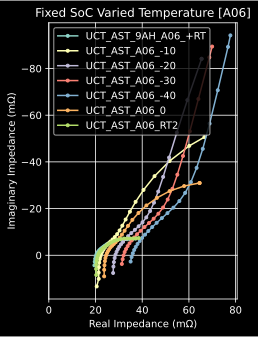

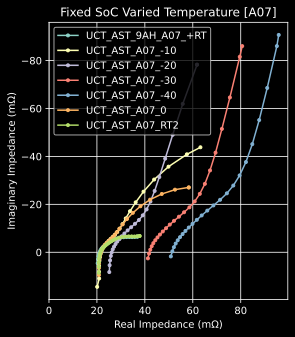

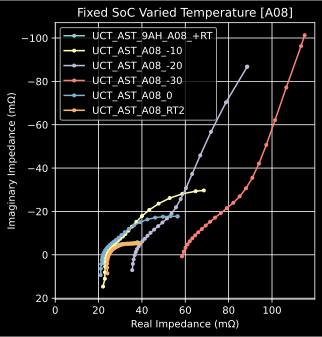

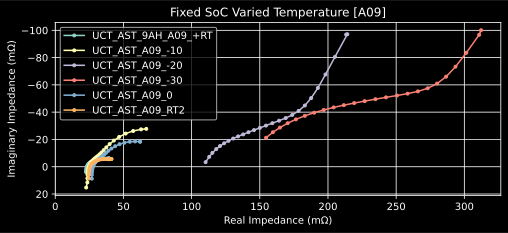

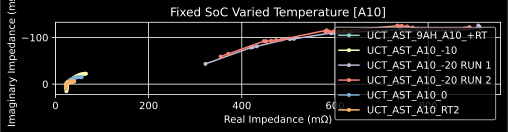

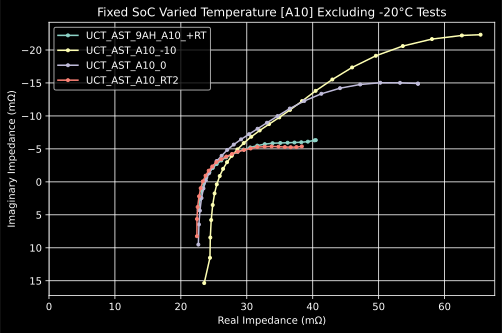

In [9]:
def plotAllSocSpectra(eisSoc):
	for battery in eisSoc:
		plot = plt.figure().add_subplot();
		for spectra in eisSoc[battery]:
			spectraLabel = eisSoc[battery][spectra][1]["Comment"]

			plot = eisSoc[battery][spectra][0].plot(
				x = 'Zreal1',
				y = 'Zimg1',
				grid = True,
				marker = '.',
				title = "Fixed SoC Varied Temperature [" + battery + "]",
				label = spectraLabel,
				ax = plot,
				legend = 'reverse'
			)
		plot.set_xlabel(nyquistRealAxisLabel)
		plot.set_ylabel(nyquistImagAxisLabel)
		plot.invert_yaxis()
		plot.set_xlim(left = 0)
		plot.set_aspect('equal', adjustable='box')

def plotA10SocSpectra(eisSoc):
	# Special plot for A10 excluding -20°C tests
	plot = plt.figure().add_subplot();
	for spectra in eisSoc["A10"]:
		if "UCT_AST_A10_-20" not in spectra:
			spectraLabel = eisSoc["A10"][spectra][1]["Comment"]

			plot = eisSoc["A10"][spectra][0].plot(
				x = 'Zreal1',
				y = 'Zimg1',
				grid = True,
				marker = '.',
				title = "Fixed SoC Varied Temperature [A10] Excluding -20°C Tests",
				label = spectraLabel,
				ax = plot,
			)
	plot.set_xlabel(nyquistRealAxisLabel)
	plot.set_ylabel(nyquistImagAxisLabel)
	plot.invert_yaxis()
	plot.set_xlim(left = 0)
	plot.set_aspect('equal', adjustable='box')
		
plotAllSocSpectra(eisSoc)
plotA10SocSpectra(eisSoc)


## Room Temperature Comparison Before/After


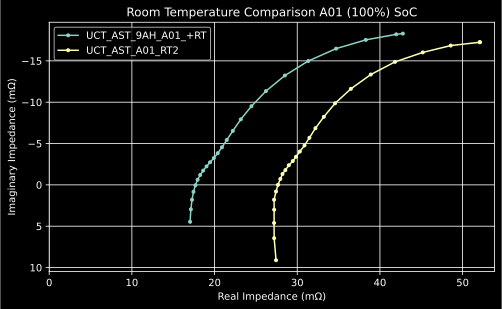

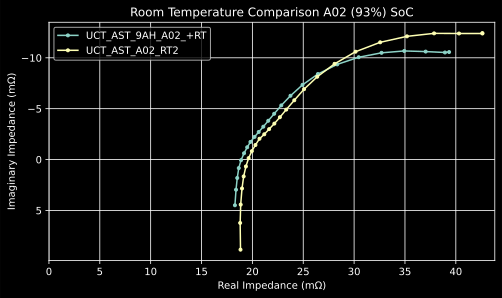

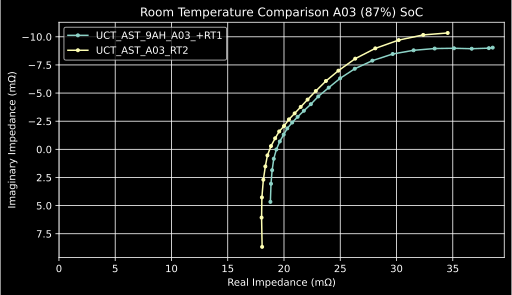

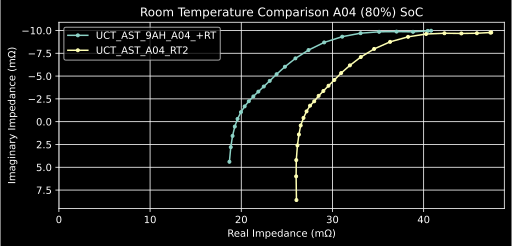

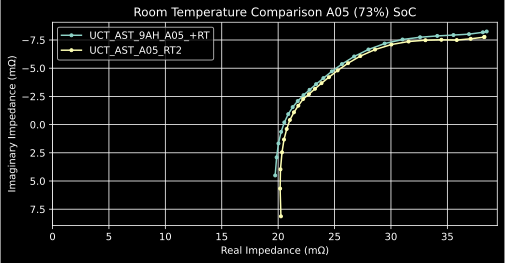

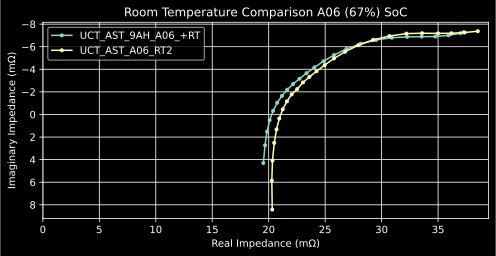

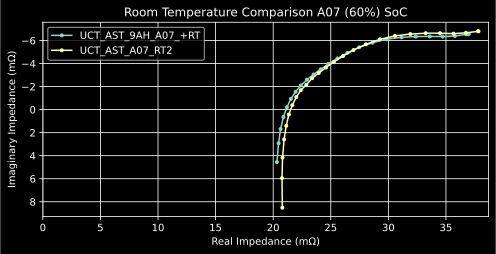

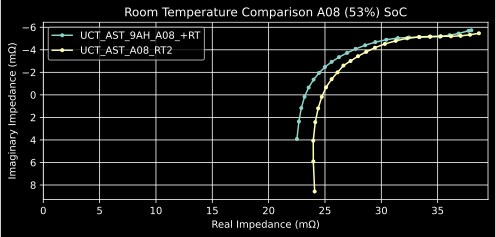

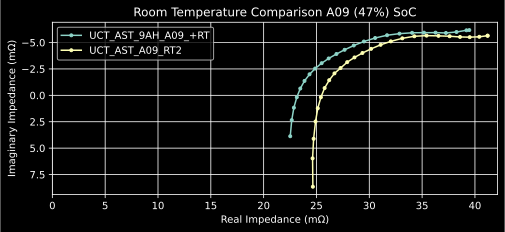

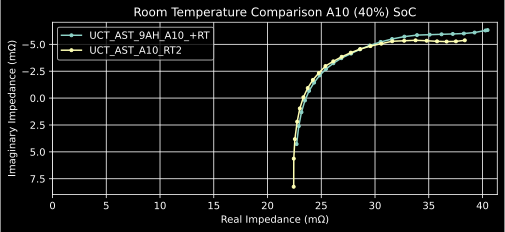

In [10]:
def collectEisRoomTemperatureComparisons(eisTemperature, socKeys):
	roomTemperatureKeys = ["RT1", "RT2"]

	eisRt1 = eisTemperature[roomTemperatureKeys[0]]
	eisRt2 = eisTemperature[roomTemperatureKeys[1]]

	eisRtCompares = {}
	for soc in socKeys:
		rt1Key = [key for key in eisRt1.keys() if soc in key][0]
		rt2Key = [key for key in eisRt2.keys() if soc in key][0]

		eisRtCompares[soc] = (eisRt1[rt1Key], eisRt2[rt2Key])

	return eisRtCompares

eisRtCompares = collectEisRoomTemperatureComparisons(eisTemperature, socMap.keys())

def plotEisRoomTemperatureComparisons(eisRtCompares):
	for soc in eisRtCompares:
		plot = plt.figure().add_subplot();

		plot = eisRtCompares[soc][0][0].plot(
			x = 'Zreal1',
			y = 'Zimg1',
			grid = True,
			marker = '.',
			label = eisRtCompares[soc][0][1]["Comment"],
			ax = plot,
			# legend = 'reverse'
		)

		plot = eisRtCompares[soc][1][0].plot(
			x = 'Zreal1',
			y = 'Zimg1',
			grid = True,
			marker = '.',
			label = eisRtCompares[soc][1][1]["Comment"],
			ax = plot,
			# legend = 'reverse'
		)

		plot.set_title(f"Room Temperature Comparison {soc} ({socMap[soc]}) SoC")
		plot.set_xlabel(nyquistRealAxisLabel)
		plot.set_ylabel(nyquistImagAxisLabel)
		plot.invert_yaxis()
		plot.set_xlim(left = 0)
		plot.set_aspect('equal', adjustable='box')

plotEisRoomTemperatureComparisons(eisRtCompares)


## Bode Plots


In [11]:
def plotBode(spectra):
	fig, ax1 = plt.subplots(figsize=(8, 5))
	ax2 = ax1.twinx()

	# Plot impedance modulus
	ax1.plot(spectra[0]['ActFreq'], spectra[0]['NomVal1'], marker='.', color='blue')
	ax1.set_xscale('log')
	ax1.set_xlabel('Frequency (Hz)')

	ax1.set_ylabel('Impedance Modulus (mΩ)')
	ax1.set_ylim(bottom=0)
	
	ax1.set_title(f"Bode Plot {spectra[1]['Comment']}")
	ax1.grid(True)

	# Plot phase
	ax2.plot(spectra[0]['ActFreq'], spectra[0]['Phase1'], marker='.', color='red')
	ax2.set_xscale('log')
	ax2.set_ylabel('Phase (°)')

	plt.tight_layout()
	plt.show()

def plotAllBode(eis):
	for spectra in eis:
		plotBode(eis[spectra])

# plotAllBode(eis)
		

### Fixed Temperature Varied SoC Bode Plots


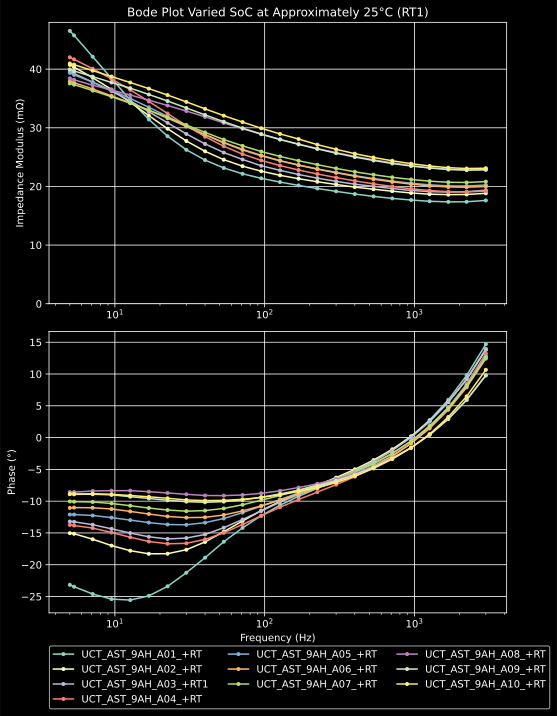

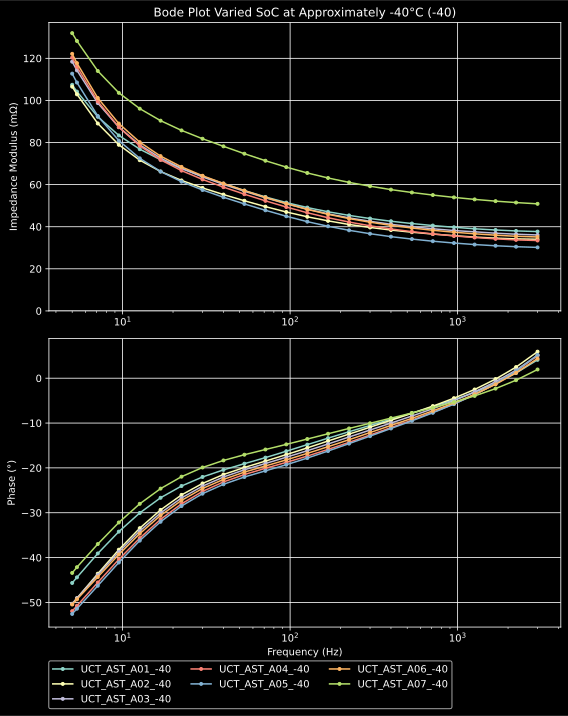

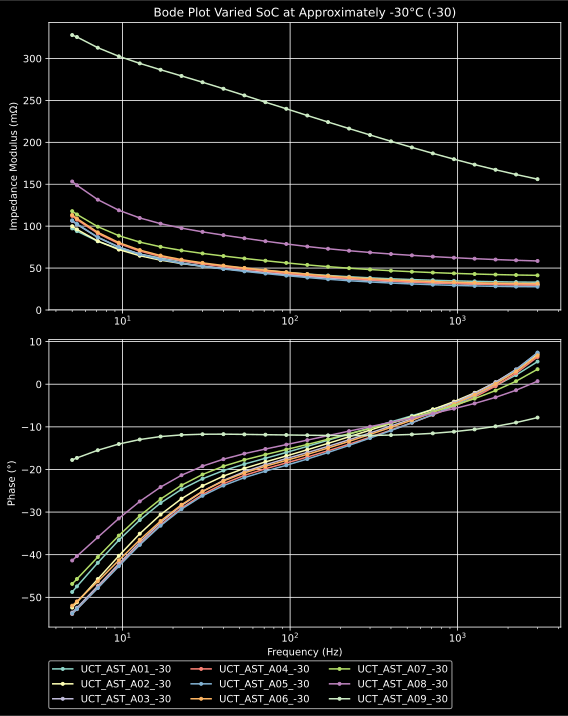

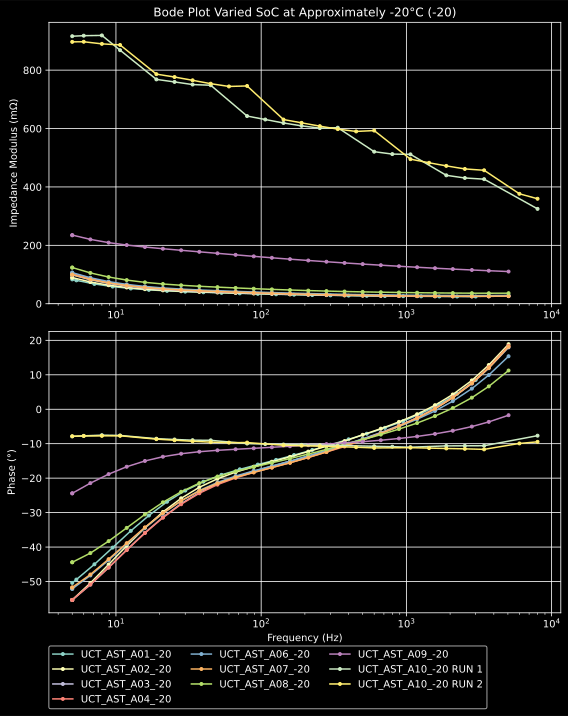

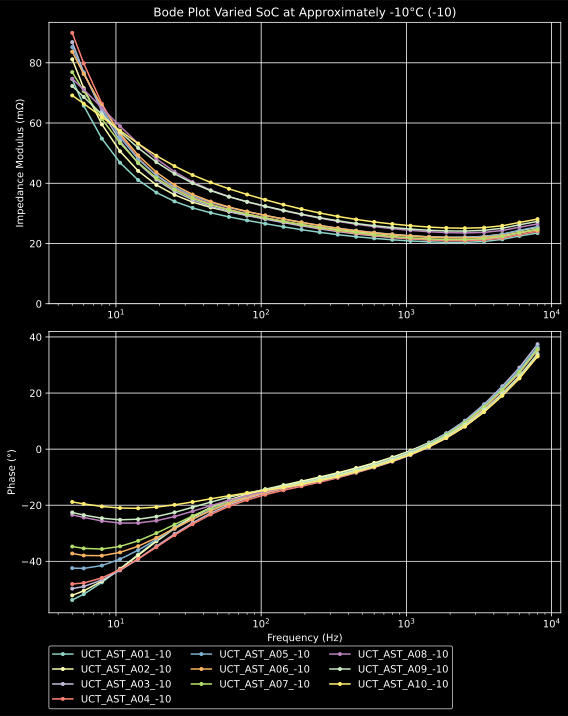

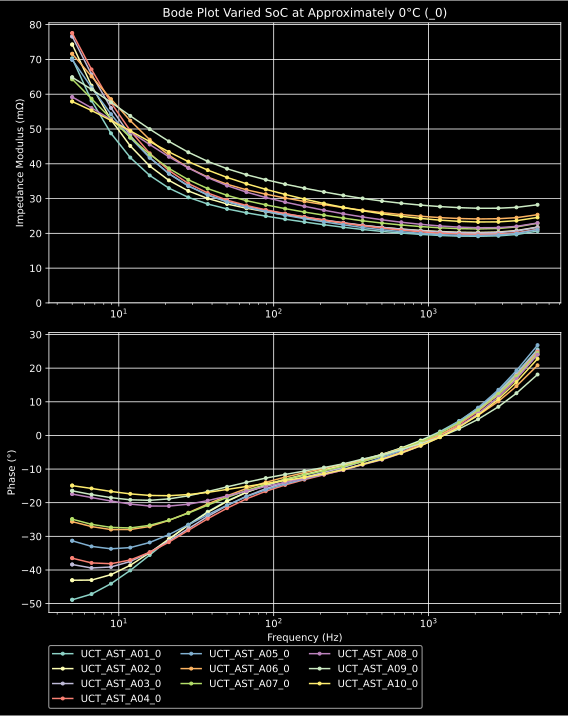

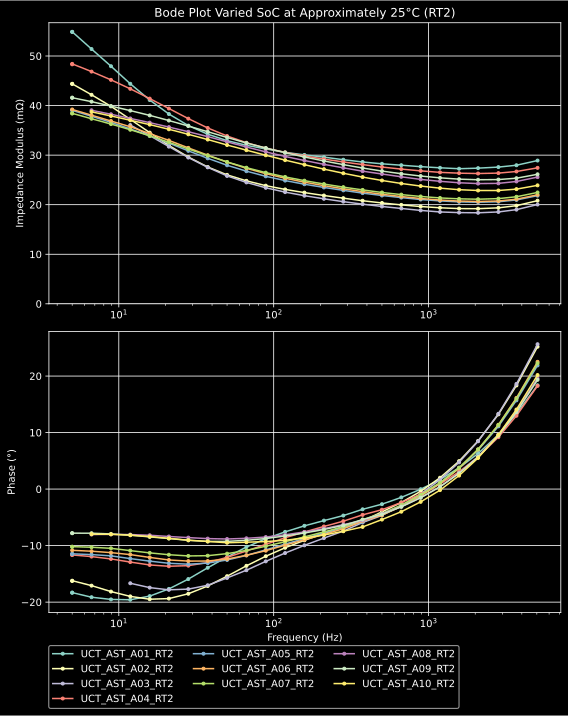

In [12]:
def plotAllTemperatureBode(eisTemperature):
	for category in eisTemperature:
		fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

		for spectra in eisTemperature[category]:
			ax1.plot(
				eisTemperature[category][spectra][0]['ActFreq'],
				eisTemperature[category][spectra][0]['NomVal1'],
				marker='.',
			)
			ax2.plot(
				eisTemperature[category][spectra][0]['ActFreq'],
				eisTemperature[category][spectra][0]['Phase1'],
				marker='.',
				label=eisTemperature[category][spectra][1]['Comment'],
			)

		ax1.set_ylabel('Impedance Modulus (mΩ)')
		ax1.set_ylim(bottom=0)
		ax1.set_xscale('log')
		ax1.set_title(f"Bode Plot Varied SoC at Approximately {temperatureMap[category]}°C ({category})")
		ax1.grid(True)

		ax2.set_xlabel('Frequency (Hz)')
		ax2.set_xscale('log')
		ax2.set_ylabel('Phase (°)')
		ax2.grid(True)
		ax2.legend(loc='upper left', bbox_to_anchor=(-0.01, -0.1), ncol=3)

		plt.tight_layout()
		plt.show()

plotAllTemperatureBode(eisTemperature)

### Fixed SoC Varied Temperature Bode Plots


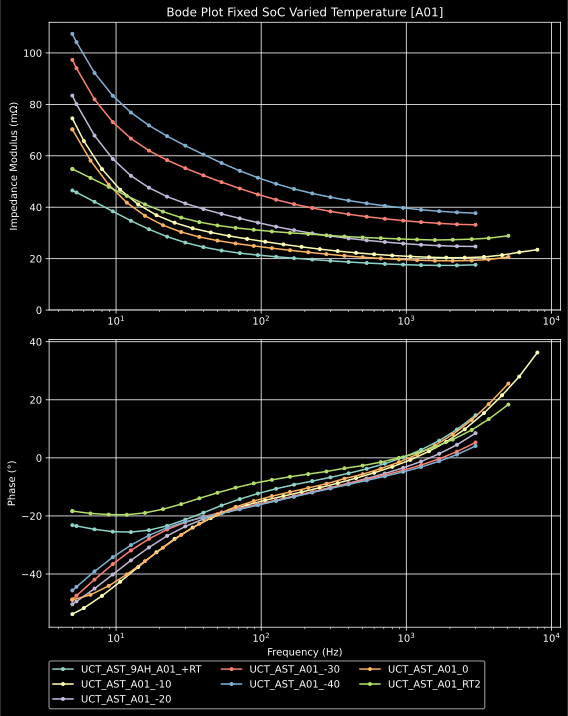

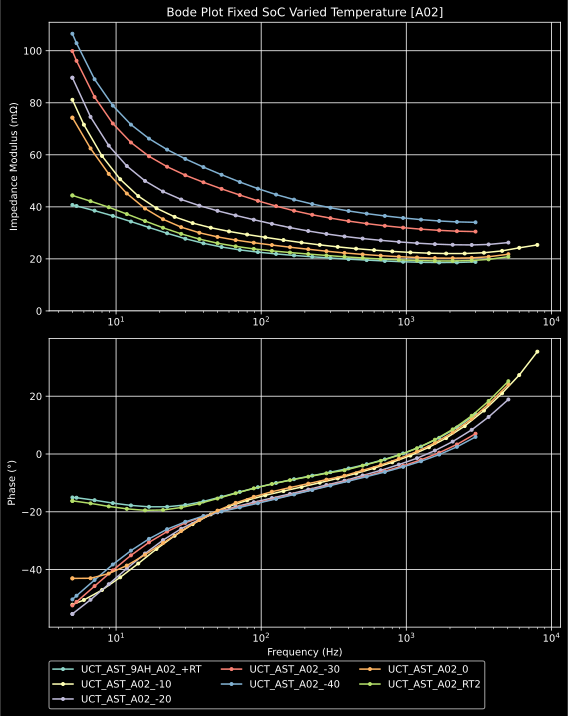

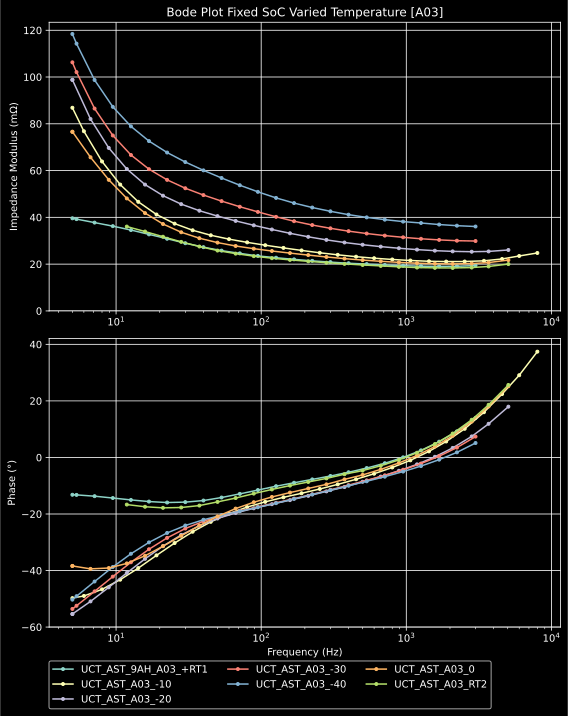

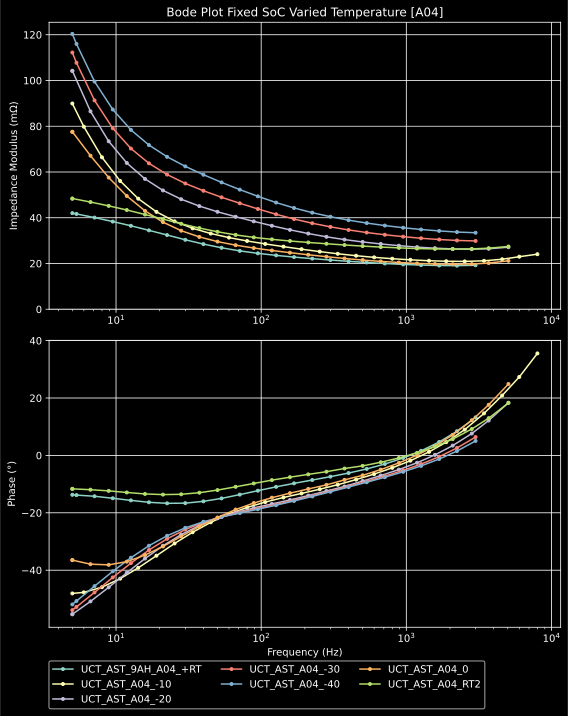

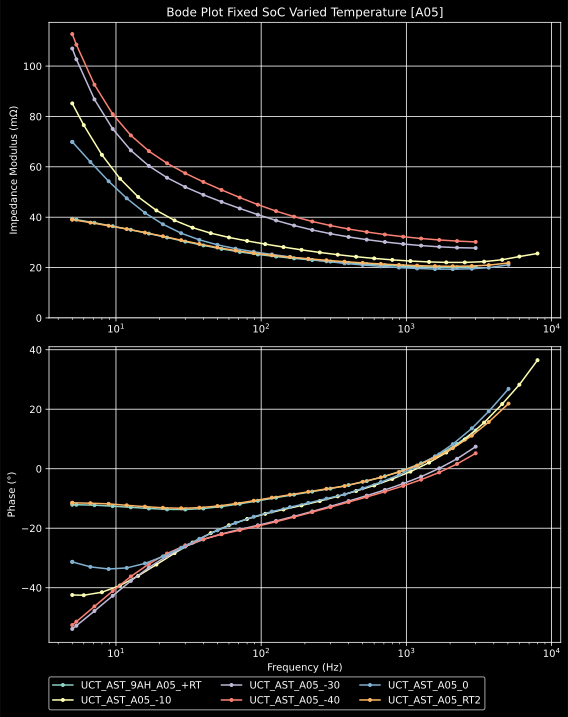

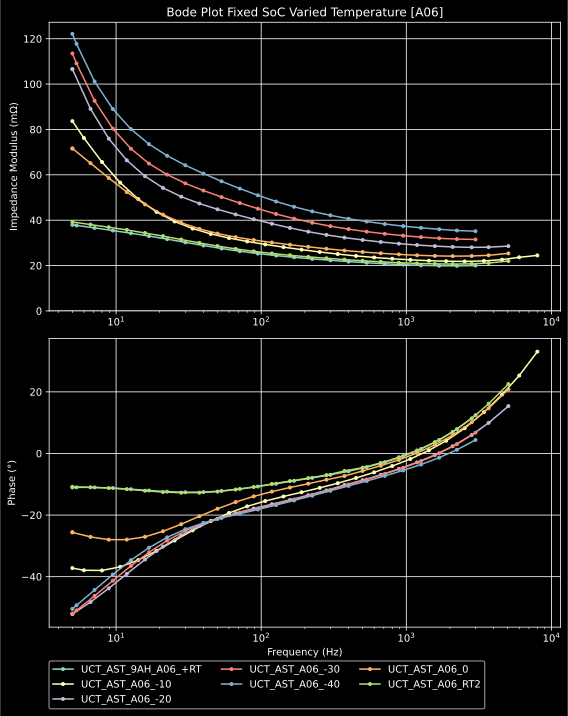

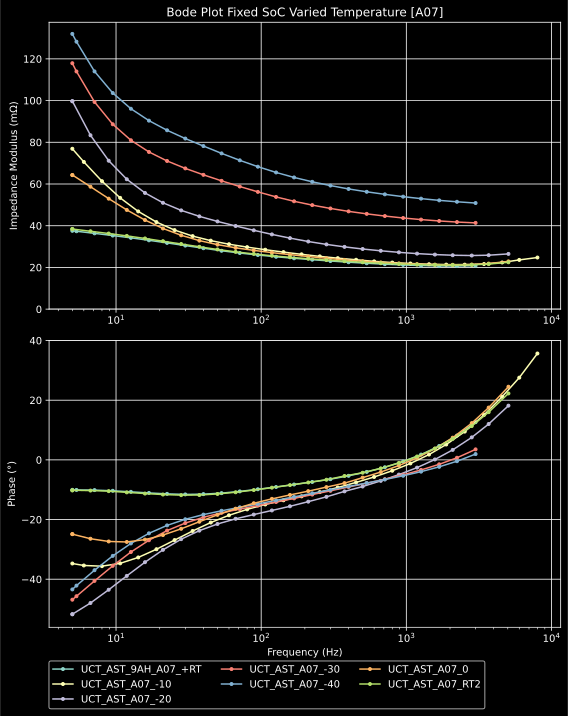

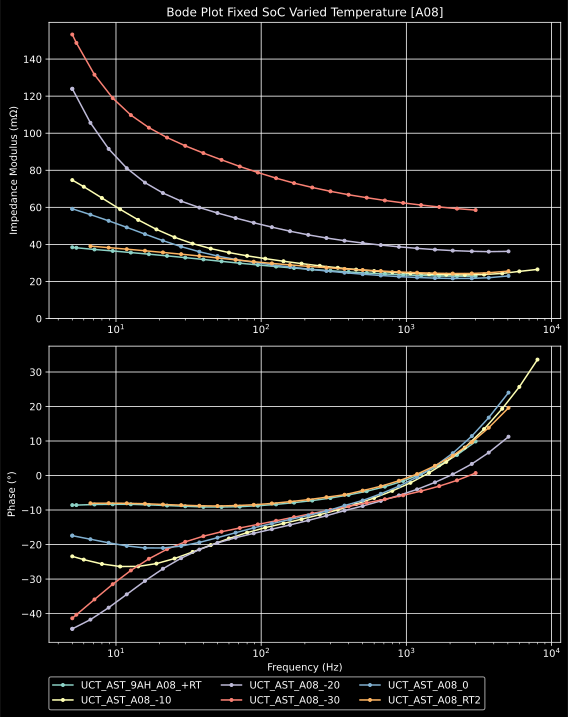

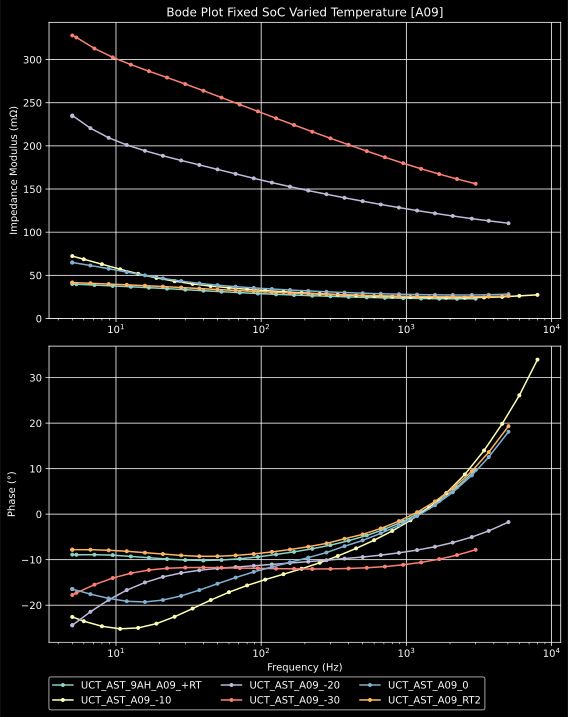

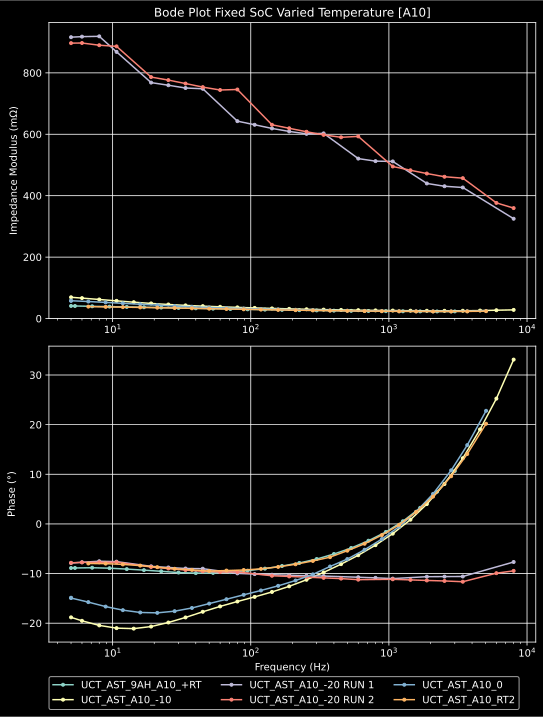

In [13]:
def plotAllSocBode(eisSoc):
	for battery in eisSoc:
		fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

		for spectra in eisSoc[battery]:
			ax1.plot(
				eisSoc[battery][spectra][0]['ActFreq'],
				eisSoc[battery][spectra][0]['NomVal1'],
				marker='.',
			)
			ax2.plot(
				eisSoc[battery][spectra][0]['ActFreq'],
				eisSoc[battery][spectra][0]['Phase1'],
				marker='.',
				label=eisSoc[battery][spectra][1]['Comment'],
			)

		ax1.set_ylabel('Impedance Modulus (mΩ)')
		ax1.set_ylim(bottom=0)
		ax1.set_xscale('log')
		ax1.set_title(f"Bode Plot Fixed SoC Varied Temperature [{battery}]")
		ax1.grid(True)

		ax2.set_xlabel('Frequency (Hz)')
		ax2.set_xscale('log')
		ax2.set_ylabel('Phase (°)')
		ax2.grid(True)
		ax2.legend(loc='upper left', bbox_to_anchor=(-0.01, -0.1), ncol=3)

		plt.tight_layout()
		plt.show()

plotAllSocBode(eisSoc)

## DC Voltage Profiles


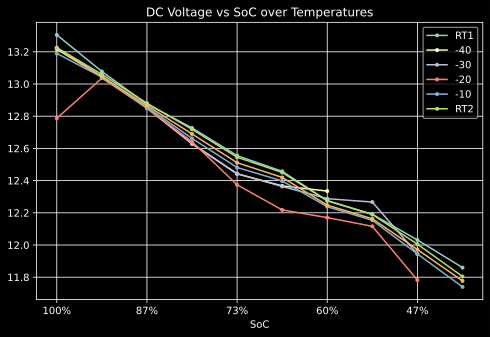

In [14]:
def plotDcVoltagesTemperature(eisTemperature):
	# For each temperature category map SoC to DC voltage
	fig, ax = plt.subplots()

	for temp in eisTemperature:
		# Make a dataframe of SoC and DC voltage from EIS metadata
		socDcVoltage = pd.DataFrame({spectra[1]['SoC']: spectra[1]['DcVoltage'] for spectra in eisTemperature[temp].values()}.items(), columns=['SoC', 'DcVoltage'])
		
		# Plot DC voltage vs SoC
		plot = socDcVoltage.plot(
			x='SoC',
			y='DcVoltage',
			title=f"DC Voltage vs SoC over Temperatures",
			grid=True,
			label=temp,
			figsize=(8, 5),
			marker='.',
			ax=ax,
		)

plotDcVoltagesTemperature(eisTemperature)
